# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_small_ip_layer = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_small_ip_layer, large_ip_layer]) 
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1) 
    output_layer = separable_conv2d_batchnorm( output_layer, filters, strides=1) 
    
    return output_layer


### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    print("Inputs  shape:",inputs.shape, "  \tImage Size in Pixels")
    
    layer01 = encoder_block(inputs , filters=32 , strides=2)
    print("layer01 shape:",layer01.shape, "  \tEncoder Block 1")
    
    layer02 = encoder_block(layer01, filters=64 , strides=2)
    print("layer02 shape:",layer02.shape, "  \tEncoder Block 2")
    
    layer03 = encoder_block(layer02, filters=128, strides=2)
    print("layer03 shape:",layer03.shape, "\tEncoder Block 3")

    # Add 1x1 Convolution layer using conv2d_batchnorm().
    layer04 = conv2d_batchnorm(layer03, filters=256, kernel_size=1, strides=1)
    print("layer04 shape:",layer04.shape, "\t1x1 Conv Layer")
    
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    layer05 = decoder_block(layer04, layer02, filters=128 )
    print("layer05 shape:",layer05.shape, "\tDecoder Block 1")
    
    layer06 = decoder_block(layer05, layer01, filters=64  )
    print("layer06 shape:",layer06.shape, "  \tDecoder Block 2")
    
    layer07 = decoder_block(layer06, inputs , filters=32  )
    print("layer07 shape:",layer07.shape, "\tDecoder Block 3")
    
    # The function returns the output layer of your model. "layer07" is the final layer obtained from the last decoder_block()
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(layer07)
    print("Outputs shape:",outputs.shape, "\tOutput Size in Pixel")
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Inputs  shape: (?, 160, 160, 3)   	Image Size in Pixels
layer01 shape: (?, 80, 80, 32)   	Encoder Block 1
layer02 shape: (?, 40, 40, 64)   	Encoder Block 2
layer03 shape: (?, 20, 20, 128) 	Encoder Block 3
layer04 shape: (?, 20, 20, 256) 	1x1 Conv Layer
layer05 shape: (?, 40, 40, 128) 	Decoder Block 1
layer06 shape: (?, 80, 80, 64)   	Decoder Block 2
layer07 shape: (?, 160, 160, 32) 	Decoder Block 3
Outputs shape: (?, 160, 160, 3) 	Output Size in Pixel


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001
batch_size = 100
num_epochs = 100
steps_per_epoch = 41
validation_steps = 12
workers = 4

Epoch 1/100
40/41 [============================>.] - ETA: 1s - loss: 1.0102

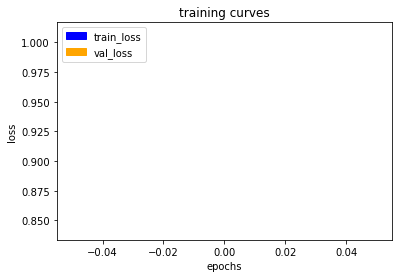

41/41 [==============================] - 80s - loss: 1.0058 - val_loss: 0.8419
Epoch 2/100
40/41 [============================>.] - ETA: 1s - loss: 0.6609

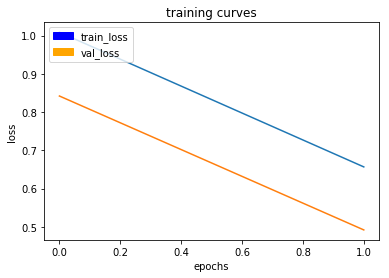

41/41 [==============================] - 76s - loss: 0.6568 - val_loss: 0.4922
Epoch 3/100
40/41 [============================>.] - ETA: 1s - loss: 0.3633

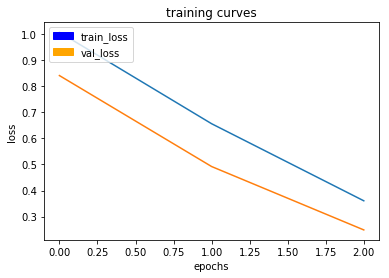

41/41 [==============================] - 75s - loss: 0.3606 - val_loss: 0.2485
Epoch 4/100
40/41 [============================>.] - ETA: 1s - loss: 0.1929

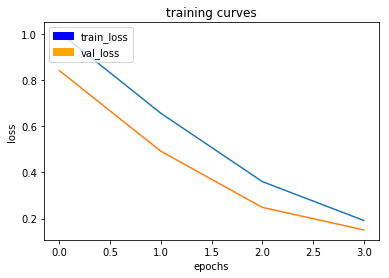

41/41 [==============================] - 77s - loss: 0.1917 - val_loss: 0.1507
Epoch 5/100
40/41 [============================>.] - ETA: 1s - loss: 0.1183

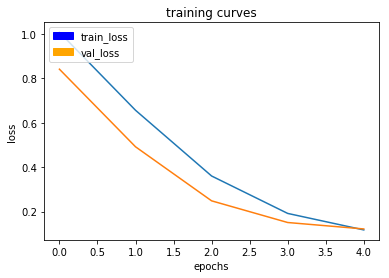

41/41 [==============================] - 75s - loss: 0.1177 - val_loss: 0.1217
Epoch 6/100
40/41 [============================>.] - ETA: 1s - loss: 0.0845

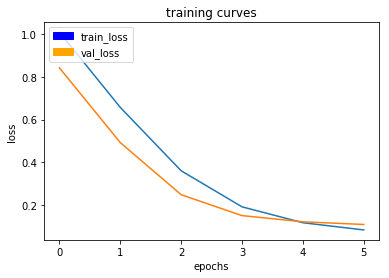

41/41 [==============================] - 75s - loss: 0.0841 - val_loss: 0.1092
Epoch 7/100
40/41 [============================>.] - ETA: 1s - loss: 0.0668

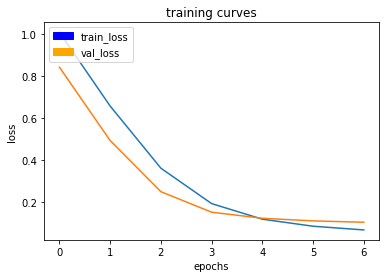

41/41 [==============================] - 75s - loss: 0.0665 - val_loss: 0.1028
Epoch 8/100
40/41 [============================>.] - ETA: 1s - loss: 0.0545

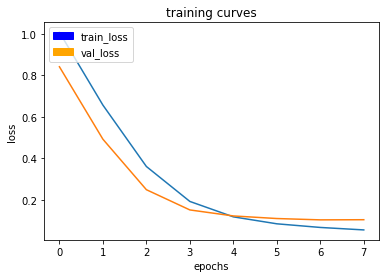

41/41 [==============================] - 75s - loss: 0.0543 - val_loss: 0.1035
Epoch 9/100
40/41 [============================>.] - ETA: 1s - loss: 0.0461

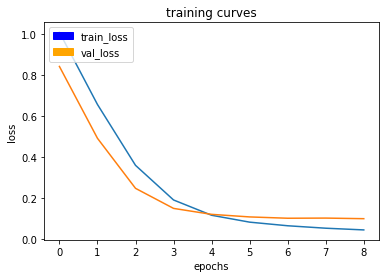

41/41 [==============================] - 75s - loss: 0.0460 - val_loss: 0.1007
Epoch 10/100
40/41 [============================>.] - ETA: 1s - loss: 0.0445

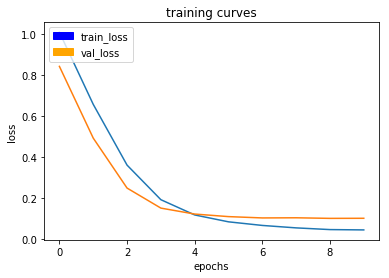

41/41 [==============================] - 75s - loss: 0.0444 - val_loss: 0.1011
Epoch 11/100
40/41 [============================>.] - ETA: 1s - loss: 0.0387

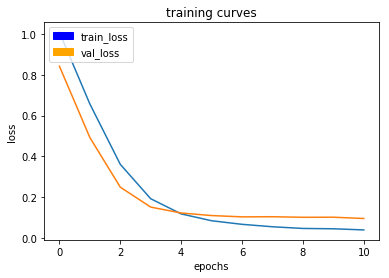

41/41 [==============================] - 76s - loss: 0.0388 - val_loss: 0.0948
Epoch 12/100
40/41 [============================>.] - ETA: 1s - loss: 0.0354

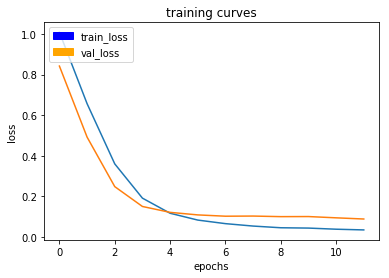

41/41 [==============================] - 75s - loss: 0.0353 - val_loss: 0.0890
Epoch 13/100
40/41 [============================>.] - ETA: 1s - loss: 0.0347

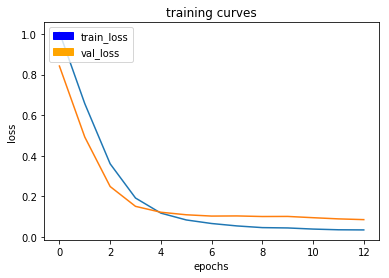

41/41 [==============================] - 76s - loss: 0.0346 - val_loss: 0.0853
Epoch 14/100
40/41 [============================>.] - ETA: 1s - loss: 0.0342

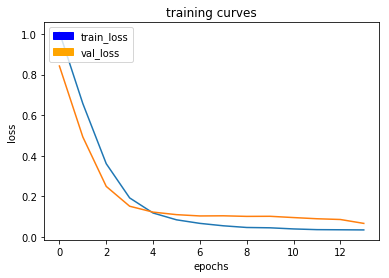

41/41 [==============================] - 76s - loss: 0.0340 - val_loss: 0.0661
Epoch 15/100
40/41 [============================>.] - ETA: 1s - loss: 0.0299

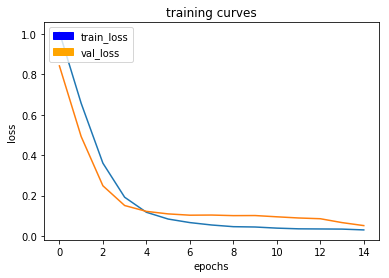

41/41 [==============================] - 75s - loss: 0.0299 - val_loss: 0.0513
Epoch 16/100
40/41 [============================>.] - ETA: 1s - loss: 0.0298

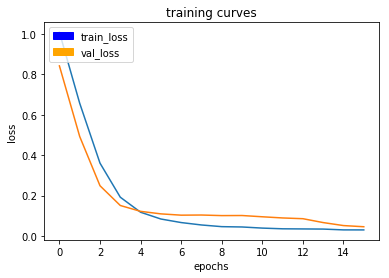

41/41 [==============================] - 75s - loss: 0.0298 - val_loss: 0.0455
Epoch 17/100
40/41 [============================>.] - ETA: 1s - loss: 0.0287

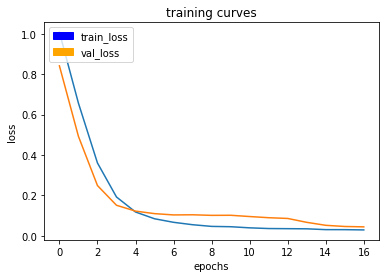

41/41 [==============================] - 76s - loss: 0.0286 - val_loss: 0.0437
Epoch 18/100
40/41 [============================>.] - ETA: 1s - loss: 0.0281

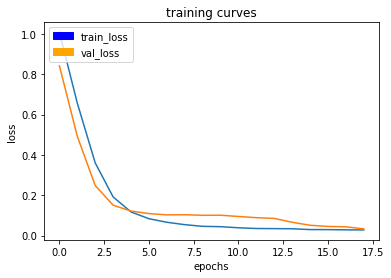

41/41 [==============================] - 75s - loss: 0.0282 - val_loss: 0.0333
Epoch 19/100
40/41 [============================>.] - ETA: 1s - loss: 0.0255

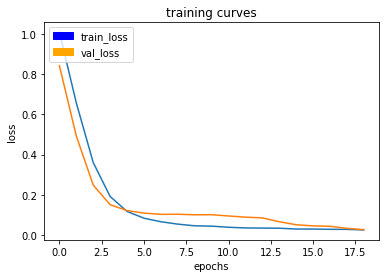

41/41 [==============================] - 75s - loss: 0.0255 - val_loss: 0.0269
Epoch 20/100
40/41 [============================>.] - ETA: 1s - loss: 0.0263

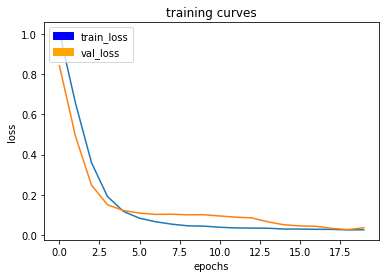

41/41 [==============================] - 76s - loss: 0.0262 - val_loss: 0.0366
Epoch 21/100
40/41 [============================>.] - ETA: 1s - loss: 0.0242

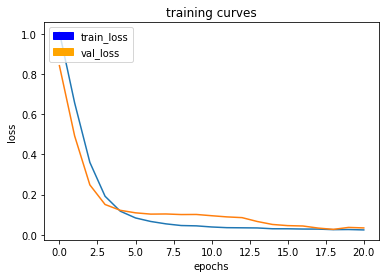

41/41 [==============================] - 76s - loss: 0.0241 - val_loss: 0.0340
Epoch 22/100
40/41 [============================>.] - ETA: 1s - loss: 0.0285

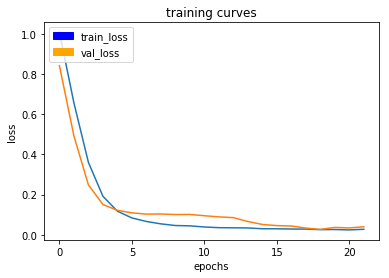

41/41 [==============================] - 76s - loss: 0.0285 - val_loss: 0.0397
Epoch 23/100
40/41 [============================>.] - ETA: 1s - loss: 0.0255

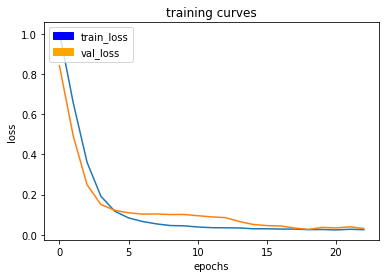

41/41 [==============================] - 75s - loss: 0.0254 - val_loss: 0.0310
Epoch 24/100
40/41 [============================>.] - ETA: 1s - loss: 0.0222

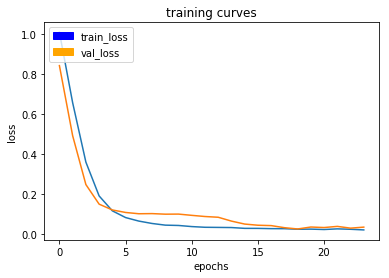

41/41 [==============================] - 75s - loss: 0.0222 - val_loss: 0.0360
Epoch 25/100
40/41 [============================>.] - ETA: 1s - loss: 0.0226

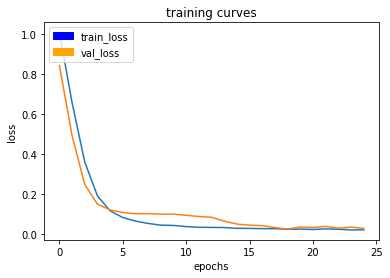

41/41 [==============================] - 75s - loss: 0.0225 - val_loss: 0.0302
Epoch 26/100
40/41 [============================>.] - ETA: 1s - loss: 0.0220

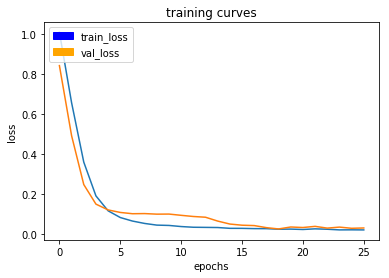

41/41 [==============================] - 76s - loss: 0.0220 - val_loss: 0.0317
Epoch 27/100
40/41 [============================>.] - ETA: 1s - loss: 0.0202

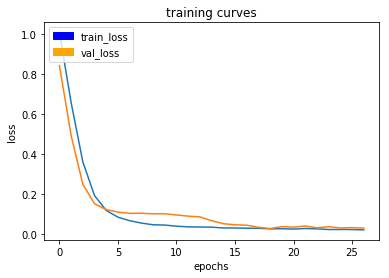

41/41 [==============================] - 75s - loss: 0.0202 - val_loss: 0.0291
Epoch 28/100
40/41 [============================>.] - ETA: 1s - loss: 0.0219

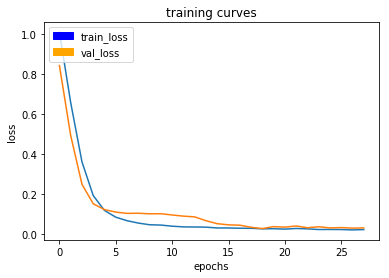

41/41 [==============================] - 76s - loss: 0.0218 - val_loss: 0.0301
Epoch 29/100
40/41 [============================>.] - ETA: 1s - loss: 0.0199

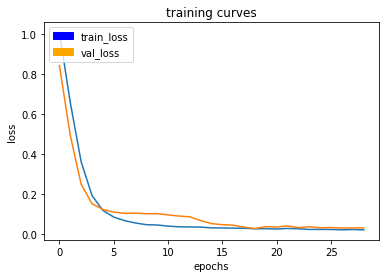

41/41 [==============================] - 75s - loss: 0.0198 - val_loss: 0.0297
Epoch 30/100
40/41 [============================>.] - ETA: 1s - loss: 0.0198

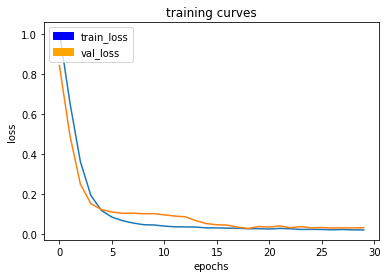

41/41 [==============================] - 76s - loss: 0.0198 - val_loss: 0.0310
Epoch 31/100
40/41 [============================>.] - ETA: 1s - loss: 0.0196

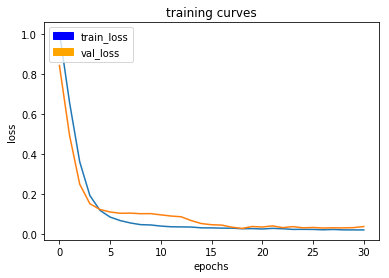

41/41 [==============================] - 76s - loss: 0.0195 - val_loss: 0.0365
Epoch 32/100
40/41 [============================>.] - ETA: 1s - loss: 0.0189

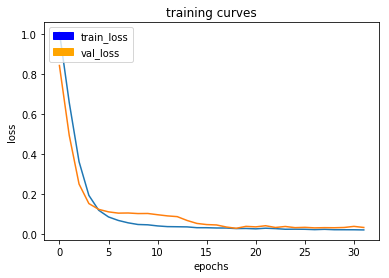

41/41 [==============================] - 75s - loss: 0.0189 - val_loss: 0.0310
Epoch 33/100
40/41 [============================>.] - ETA: 1s - loss: 0.0198

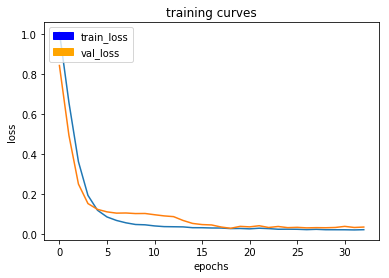

41/41 [==============================] - 76s - loss: 0.0200 - val_loss: 0.0331
Epoch 34/100
40/41 [============================>.] - ETA: 1s - loss: 0.0201

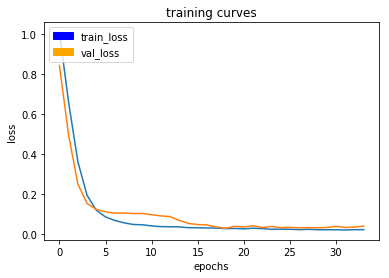

41/41 [==============================] - 75s - loss: 0.0201 - val_loss: 0.0377
Epoch 35/100
40/41 [============================>.] - ETA: 1s - loss: 0.0184

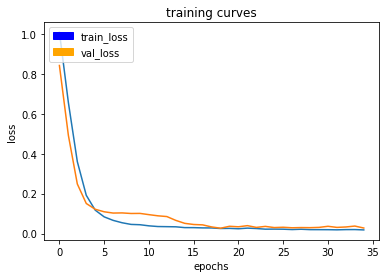

41/41 [==============================] - 76s - loss: 0.0184 - val_loss: 0.0278
Epoch 36/100
40/41 [============================>.] - ETA: 1s - loss: 0.0176

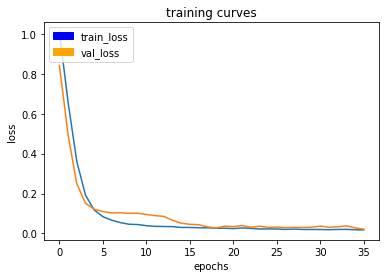

41/41 [==============================] - 76s - loss: 0.0176 - val_loss: 0.0213
Epoch 37/100
40/41 [============================>.] - ETA: 1s - loss: 0.0179

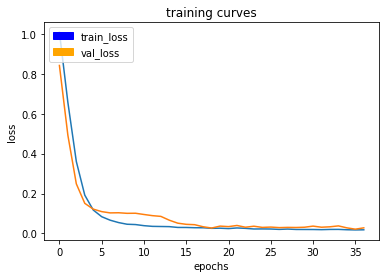

41/41 [==============================] - 76s - loss: 0.0180 - val_loss: 0.0279
Epoch 38/100
40/41 [============================>.] - ETA: 1s - loss: 0.0178

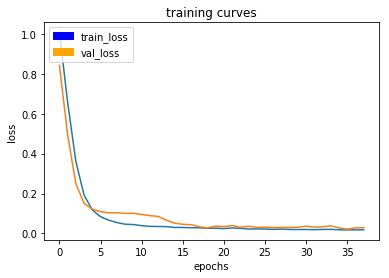

41/41 [==============================] - 75s - loss: 0.0178 - val_loss: 0.0285
Epoch 39/100
40/41 [============================>.] - ETA: 1s - loss: 0.0172

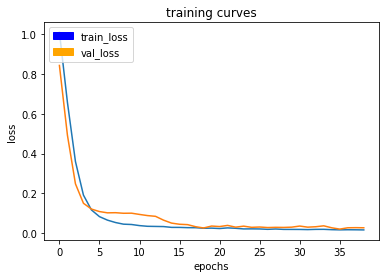

41/41 [==============================] - 76s - loss: 0.0171 - val_loss: 0.0279
Epoch 40/100
40/41 [============================>.] - ETA: 1s - loss: 0.0164

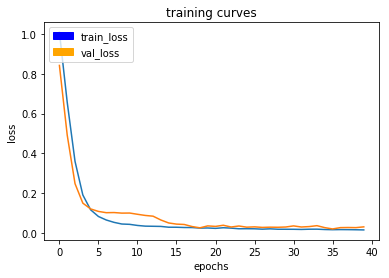

41/41 [==============================] - 75s - loss: 0.0164 - val_loss: 0.0317
Epoch 41/100
40/41 [============================>.] - ETA: 1s - loss: 0.0170

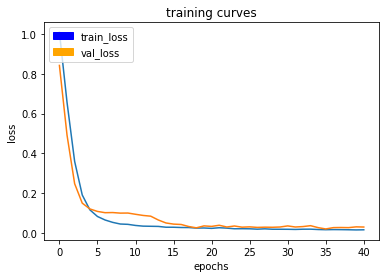

41/41 [==============================] - 75s - loss: 0.0169 - val_loss: 0.0308
Epoch 42/100
40/41 [============================>.] - ETA: 1s - loss: 0.0165

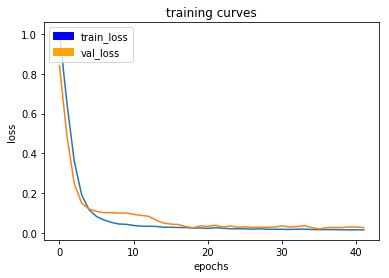

41/41 [==============================] - 76s - loss: 0.0165 - val_loss: 0.0281
Epoch 43/100
40/41 [============================>.] - ETA: 1s - loss: 0.0168

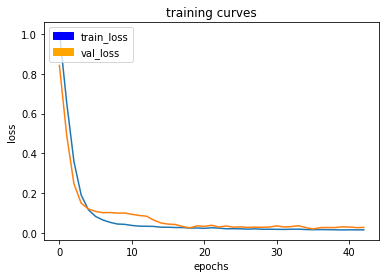

41/41 [==============================] - 76s - loss: 0.0167 - val_loss: 0.0287
Epoch 44/100
40/41 [============================>.] - ETA: 1s - loss: 0.0157

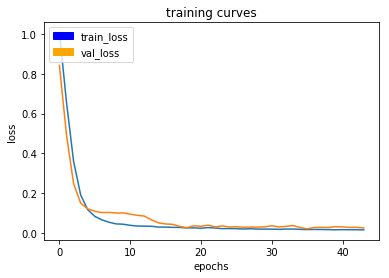

41/41 [==============================] - 76s - loss: 0.0157 - val_loss: 0.0257
Epoch 45/100
40/41 [============================>.] - ETA: 1s - loss: 0.0149

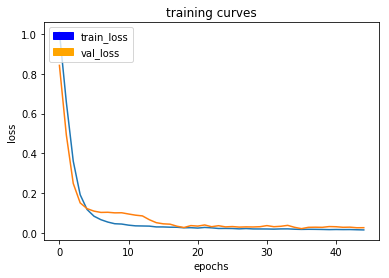

41/41 [==============================] - 76s - loss: 0.0149 - val_loss: 0.0261
Epoch 46/100
40/41 [============================>.] - ETA: 1s - loss: 0.0155

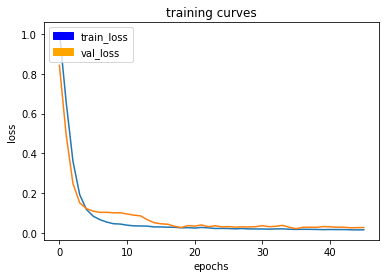

41/41 [==============================] - 76s - loss: 0.0155 - val_loss: 0.0269
Epoch 47/100
40/41 [============================>.] - ETA: 1s - loss: 0.0152

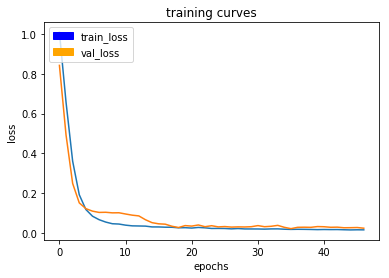

41/41 [==============================] - 76s - loss: 0.0152 - val_loss: 0.0235
Epoch 48/100
40/41 [============================>.] - ETA: 1s - loss: 0.0149

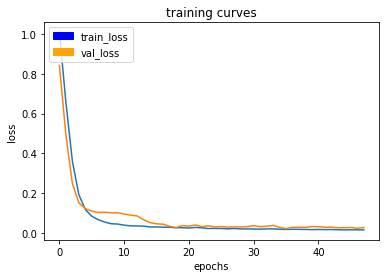

41/41 [==============================] - 76s - loss: 0.0151 - val_loss: 0.0267
Epoch 49/100
40/41 [============================>.] - ETA: 1s - loss: 0.0158

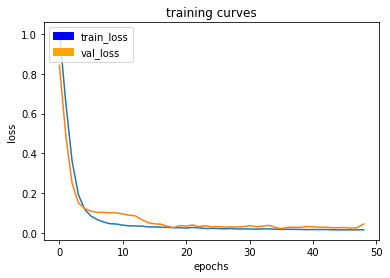

41/41 [==============================] - 76s - loss: 0.0158 - val_loss: 0.0450
Epoch 50/100
40/41 [============================>.] - ETA: 1s - loss: 0.0173

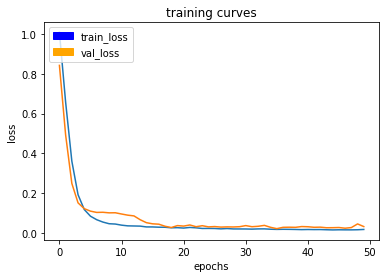

41/41 [==============================] - 75s - loss: 0.0172 - val_loss: 0.0317
Epoch 51/100
40/41 [============================>.] - ETA: 1s - loss: 0.0157

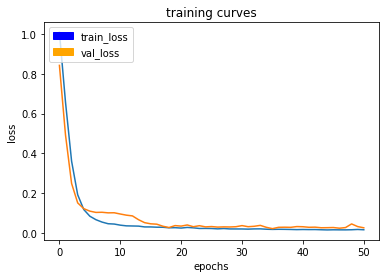

41/41 [==============================] - 75s - loss: 0.0156 - val_loss: 0.0255
Epoch 52/100
40/41 [============================>.] - ETA: 1s - loss: 0.0146

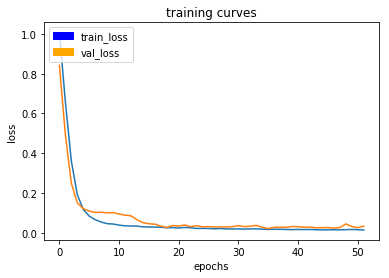

41/41 [==============================] - 76s - loss: 0.0146 - val_loss: 0.0336
Epoch 53/100
40/41 [============================>.] - ETA: 1s - loss: 0.0143

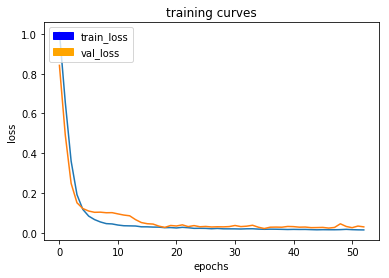

41/41 [==============================] - 75s - loss: 0.0143 - val_loss: 0.0295
Epoch 54/100
40/41 [============================>.] - ETA: 1s - loss: 0.0146

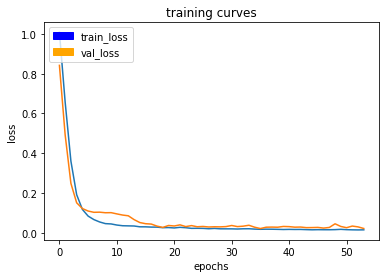

41/41 [==============================] - 76s - loss: 0.0147 - val_loss: 0.0215
Epoch 55/100
40/41 [============================>.] - ETA: 1s - loss: 0.0144

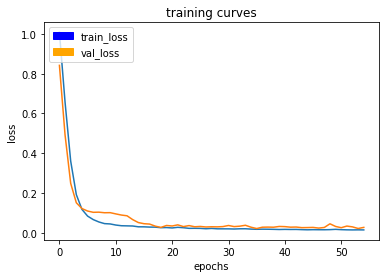

41/41 [==============================] - 76s - loss: 0.0143 - val_loss: 0.0270
Epoch 56/100
40/41 [============================>.] - ETA: 1s - loss: 0.0134

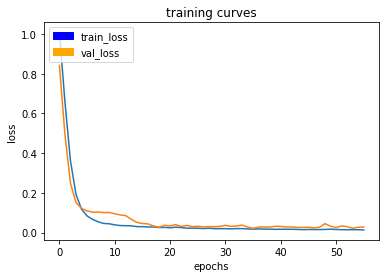

41/41 [==============================] - 76s - loss: 0.0134 - val_loss: 0.0273
Epoch 57/100
40/41 [============================>.] - ETA: 1s - loss: 0.0135

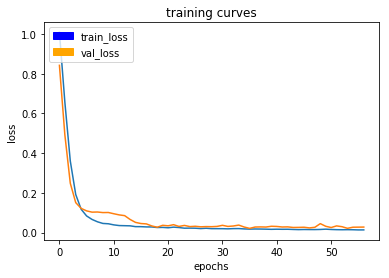

41/41 [==============================] - 75s - loss: 0.0135 - val_loss: 0.0277
Epoch 58/100
40/41 [============================>.] - ETA: 1s - loss: 0.0135

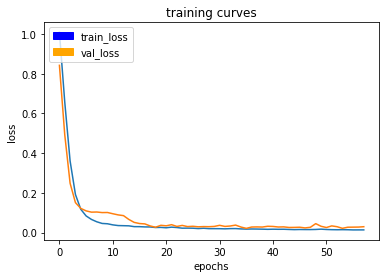

41/41 [==============================] - 77s - loss: 0.0136 - val_loss: 0.0295
Epoch 59/100
40/41 [============================>.] - ETA: 1s - loss: 0.0129

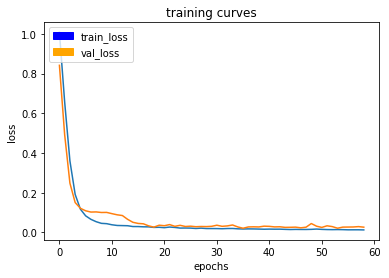

41/41 [==============================] - 75s - loss: 0.0129 - val_loss: 0.0267
Epoch 60/100
40/41 [============================>.] - ETA: 1s - loss: 0.0137

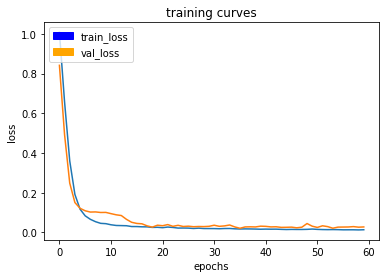

41/41 [==============================] - 76s - loss: 0.0137 - val_loss: 0.0279
Epoch 61/100
40/41 [============================>.] - ETA: 1s - loss: 0.0130

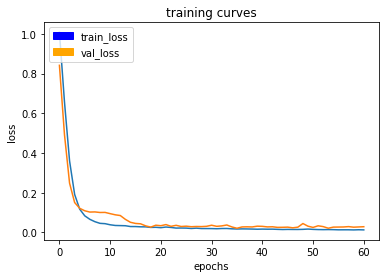

41/41 [==============================] - 75s - loss: 0.0130 - val_loss: 0.0290
Epoch 62/100
40/41 [============================>.] - ETA: 1s - loss: 0.0132

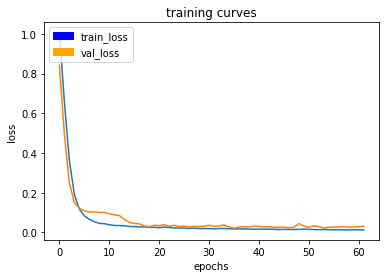

41/41 [==============================] - 76s - loss: 0.0132 - val_loss: 0.0311
Epoch 63/100
40/41 [============================>.] - ETA: 1s - loss: 0.0136

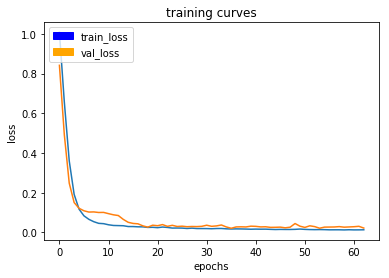

41/41 [==============================] - 76s - loss: 0.0135 - val_loss: 0.0222
Epoch 64/100
40/41 [============================>.] - ETA: 1s - loss: 0.0158

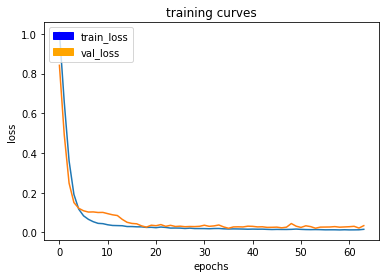

41/41 [==============================] - 76s - loss: 0.0159 - val_loss: 0.0343
Epoch 65/100
40/41 [============================>.] - ETA: 1s - loss: 0.0149

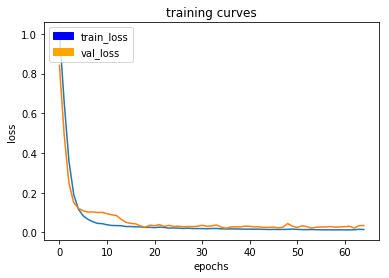

41/41 [==============================] - 75s - loss: 0.0149 - val_loss: 0.0349
Epoch 66/100
40/41 [============================>.] - ETA: 1s - loss: 0.0188

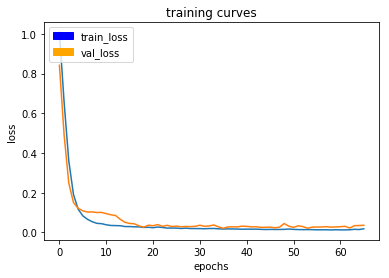

41/41 [==============================] - 76s - loss: 0.0187 - val_loss: 0.0363
Epoch 67/100
40/41 [============================>.] - ETA: 1s - loss: 0.0164

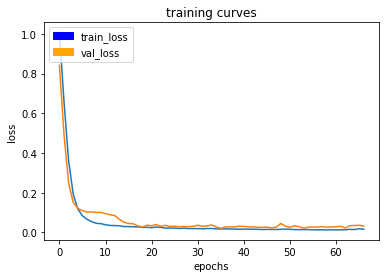

41/41 [==============================] - 76s - loss: 0.0164 - val_loss: 0.0328
Epoch 68/100
40/41 [============================>.] - ETA: 1s - loss: 0.0165

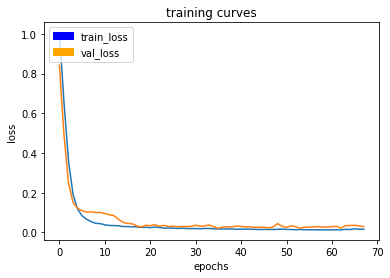

41/41 [==============================] - 76s - loss: 0.0165 - val_loss: 0.0298
Epoch 69/100
40/41 [============================>.] - ETA: 1s - loss: 0.0173

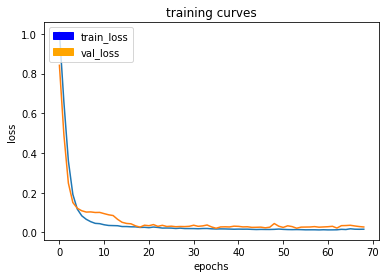

41/41 [==============================] - 75s - loss: 0.0173 - val_loss: 0.0277
Epoch 70/100
40/41 [============================>.] - ETA: 1s - loss: 0.0156

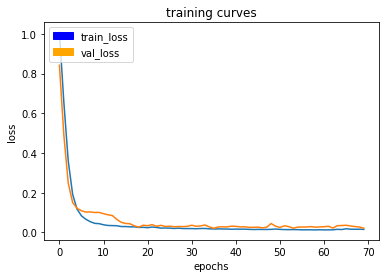

41/41 [==============================] - 75s - loss: 0.0156 - val_loss: 0.0215
Epoch 71/100
40/41 [============================>.] - ETA: 1s - loss: 0.0134

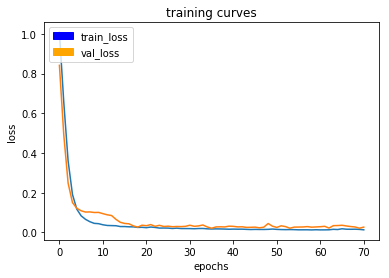

41/41 [==============================] - 75s - loss: 0.0133 - val_loss: 0.0271
Epoch 72/100
40/41 [============================>.] - ETA: 1s - loss: 0.0127

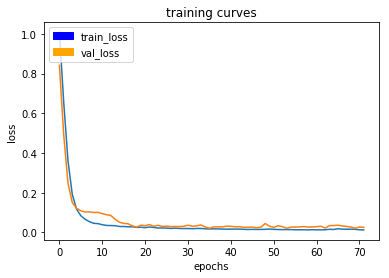

41/41 [==============================] - 75s - loss: 0.0127 - val_loss: 0.0258
Epoch 73/100
40/41 [============================>.] - ETA: 1s - loss: 0.0127

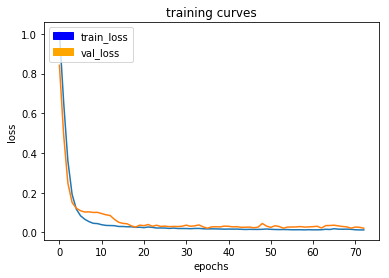

41/41 [==============================] - 75s - loss: 0.0127 - val_loss: 0.0212
Epoch 74/100
40/41 [============================>.] - ETA: 1s - loss: 0.0126

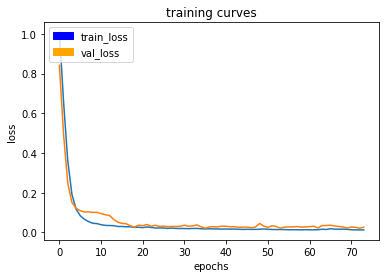

41/41 [==============================] - 75s - loss: 0.0125 - val_loss: 0.0263
Epoch 75/100
40/41 [============================>.] - ETA: 1s - loss: 0.0123

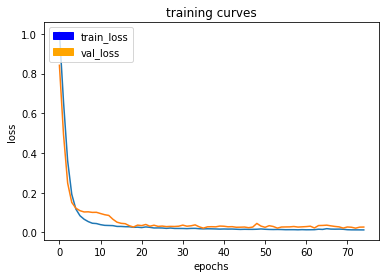

41/41 [==============================] - 75s - loss: 0.0123 - val_loss: 0.0267
Epoch 76/100
40/41 [============================>.] - ETA: 1s - loss: 0.0129

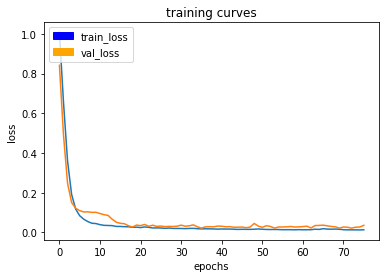

41/41 [==============================] - 75s - loss: 0.0129 - val_loss: 0.0355
Epoch 77/100
40/41 [============================>.] - ETA: 1s - loss: 0.0123

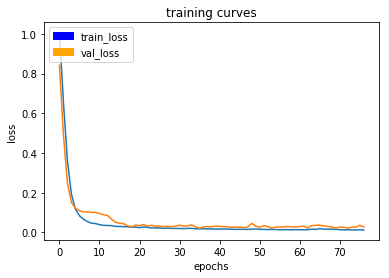

41/41 [==============================] - 76s - loss: 0.0123 - val_loss: 0.0274
Epoch 78/100
40/41 [============================>.] - ETA: 1s - loss: 0.0119

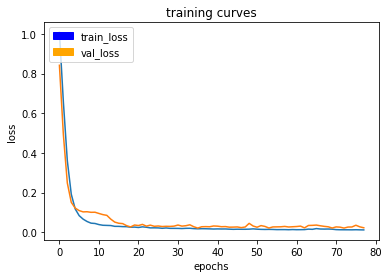

41/41 [==============================] - 75s - loss: 0.0119 - val_loss: 0.0227
Epoch 79/100
40/41 [============================>.] - ETA: 1s - loss: 0.0118

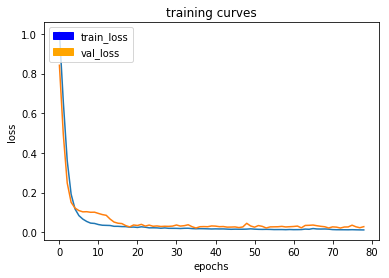

41/41 [==============================] - 76s - loss: 0.0118 - val_loss: 0.0281
Epoch 80/100
40/41 [============================>.] - ETA: 1s - loss: 0.0116

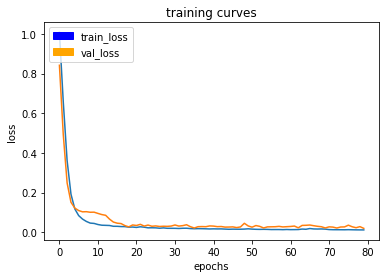

41/41 [==============================] - 76s - loss: 0.0116 - val_loss: 0.0195
Epoch 81/100
40/41 [============================>.] - ETA: 1s - loss: 0.0114

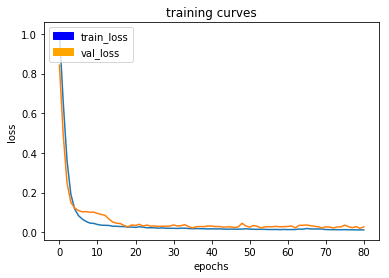

41/41 [==============================] - 76s - loss: 0.0114 - val_loss: 0.0271
Epoch 82/100
40/41 [============================>.] - ETA: 1s - loss: 0.0112

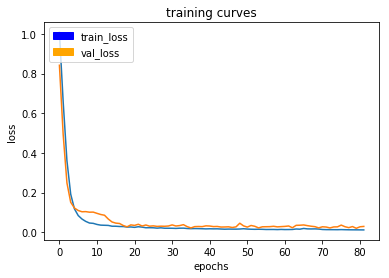

41/41 [==============================] - 76s - loss: 0.0112 - val_loss: 0.0288
Epoch 83/100
40/41 [============================>.] - ETA: 1s - loss: 0.0115

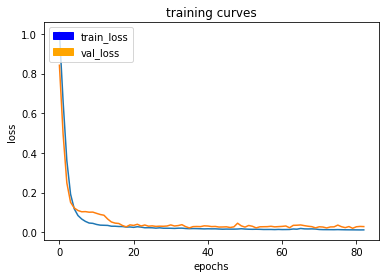

41/41 [==============================] - 75s - loss: 0.0115 - val_loss: 0.0280
Epoch 84/100
40/41 [============================>.] - ETA: 1s - loss: 0.0125

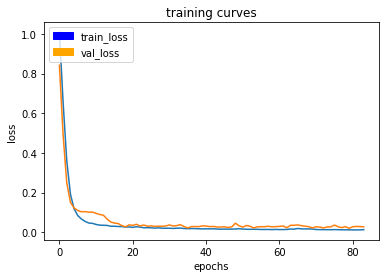

41/41 [==============================] - 75s - loss: 0.0125 - val_loss: 0.0266
Epoch 85/100
40/41 [============================>.] - ETA: 1s - loss: 0.0117

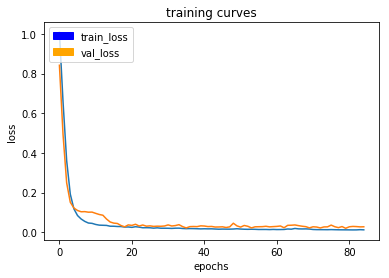

41/41 [==============================] - 76s - loss: 0.0117 - val_loss: 0.0270
Epoch 86/100
40/41 [============================>.] - ETA: 1s - loss: 0.0122

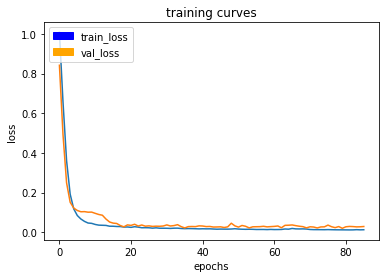

41/41 [==============================] - 76s - loss: 0.0121 - val_loss: 0.0284
Epoch 87/100
40/41 [============================>.] - ETA: 1s - loss: 0.0114

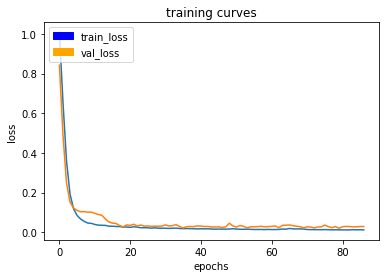

41/41 [==============================] - 74s - loss: 0.0114 - val_loss: 0.0281
Epoch 88/100
40/41 [============================>.] - ETA: 1s - loss: 0.0112

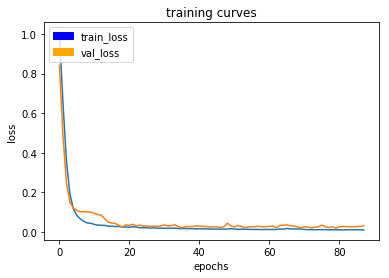

41/41 [==============================] - 77s - loss: 0.0112 - val_loss: 0.0331
Epoch 89/100
40/41 [============================>.] - ETA: 1s - loss: 0.0108

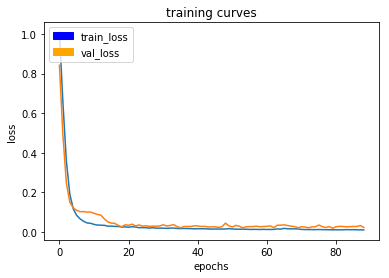

41/41 [==============================] - 76s - loss: 0.0109 - val_loss: 0.0235
Epoch 90/100
40/41 [============================>.] - ETA: 1s - loss: 0.0108

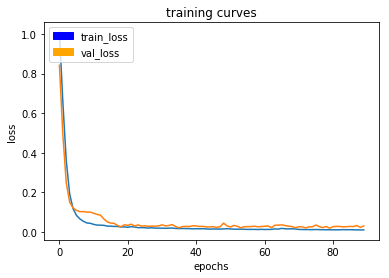

41/41 [==============================] - 75s - loss: 0.0108 - val_loss: 0.0308
Epoch 91/100
40/41 [============================>.] - ETA: 1s - loss: 0.0109

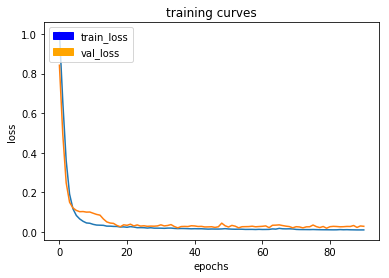

41/41 [==============================] - 75s - loss: 0.0109 - val_loss: 0.0290
Epoch 92/100
40/41 [============================>.] - ETA: 1s - loss: 0.0108

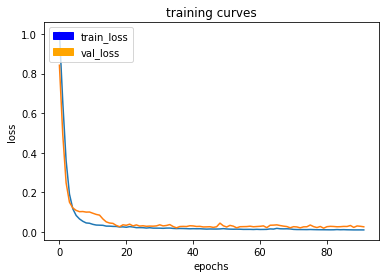

41/41 [==============================] - 75s - loss: 0.0108 - val_loss: 0.0265
Epoch 93/100
40/41 [============================>.] - ETA: 1s - loss: 0.0106

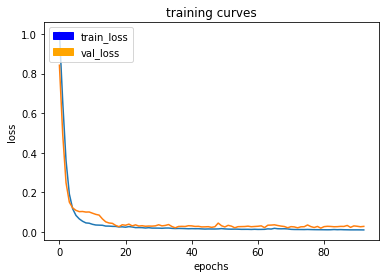

41/41 [==============================] - 76s - loss: 0.0106 - val_loss: 0.0283
Epoch 94/100
40/41 [============================>.] - ETA: 1s - loss: 0.0109

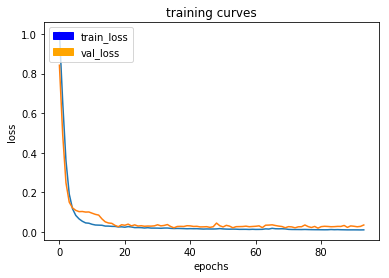

41/41 [==============================] - 76s - loss: 0.0109 - val_loss: 0.0355
Epoch 95/100
40/41 [============================>.] - ETA: 1s - loss: 0.0116

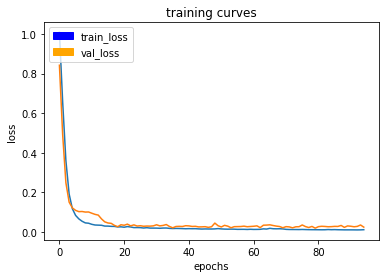

41/41 [==============================] - 75s - loss: 0.0116 - val_loss: 0.0245
Epoch 96/100
40/41 [============================>.] - ETA: 1s - loss: 0.0109

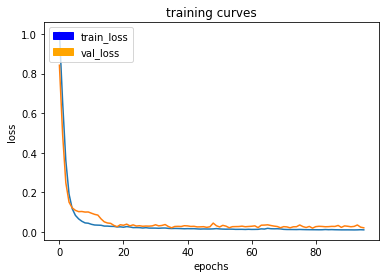

41/41 [==============================] - 76s - loss: 0.0109 - val_loss: 0.0211
Epoch 97/100
40/41 [============================>.] - ETA: 1s - loss: 0.0123

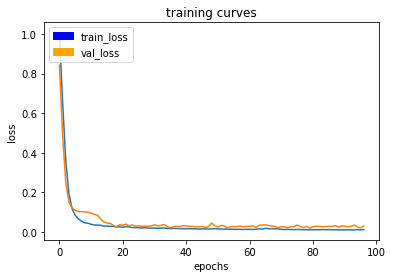

41/41 [==============================] - 76s - loss: 0.0123 - val_loss: 0.0308
Epoch 98/100
40/41 [============================>.] - ETA: 1s - loss: 0.0126

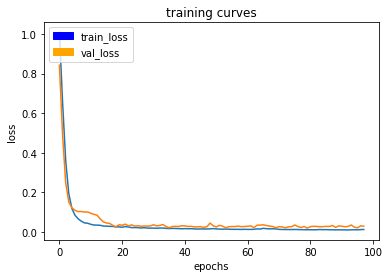

41/41 [==============================] - 75s - loss: 0.0127 - val_loss: 0.0294
Epoch 99/100
40/41 [============================>.] - ETA: 1s - loss: 0.0115

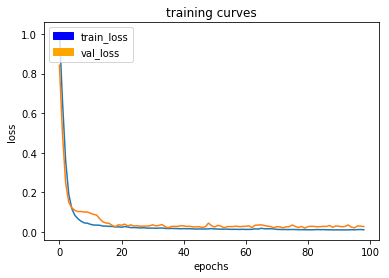

41/41 [==============================] - 76s - loss: 0.0114 - val_loss: 0.0276
Epoch 100/100
40/41 [============================>.] - ETA: 1s - loss: 0.0112

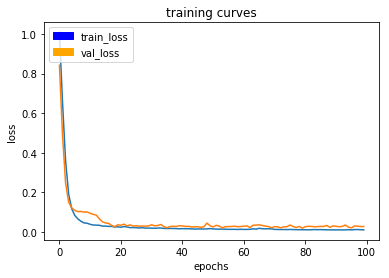

41/41 [==============================] - 76s - loss: 0.0112 - val_loss: 0.0278


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

IndexError: list index out of range

In [ ]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

In [ ]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [ ]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

In [ ]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

In [ ]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

In [ ]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

In [ ]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

In [ ]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)